# Prelim ARIMA Retro. Analysis

## notes

###### **pageviews only:**

- pick pageid(s)
- get daily views series for 2 years
- regress pageviews ~ weekends, holidays, linear trend:
    - get residuals RS_VIEWS
- lag RS_VIEWS to get RS_VIEWS_L!, L2, etc.
- regress RS_VIEWS on:
    - a naive moving average of RS_VIEWS lags
    - and some AR lags of RS_VIEWS
- do ARIMA analysis of pageviews to compare

#### later

###### **edits only:**

same thing

###### **pageviews and edits:**

- regress RS_EDITS on RS_VIEWS_L1
- regress RS_EDITS on RS_EDITS_LX and RS_VIEWS_LX

## setup

#### initial

##### imports

In [37]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, datetime as dt
import os
# from holidays_jp import CountryHolidays

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

##### mariadb

###### pass

###### connect

#### get and clean data

##### get edits, views

###### paths

In [3]:
jawiki_path = '../data/processed/jawiki/'

###### get and clean edits

In [68]:
# get edits
edits = pd.read_csv(f'{jawiki_path}disaster_allpageids_daily_edits.tsv', 
                 sep='\t', usecols=['day', 'page_id', 'edits'])
# create multiindex
edits.set_index(['day', 'page_id'], inplace=True)
# pivot multiindex wide and replace NaN with 0
edits = edits.unstack().fillna(0)
# drop a vestigial multiindex (non-informative)
edits.columns = edits.columns.droplevel(0)
# sort columns
edits.sort_index(axis=1, inplace=True)
# convert date-string index to DatetimeIndex
edits.index = pd.DatetimeIndex(edits.index).tz_localize('Japan')

###### get and clean views

In [64]:
dfs = []
# Do all files in folder. Each file is a year.
for i in os.listdir(f'{jawiki_path}views/'): 
    df = pd.read_csv(f'{jawiki_path}views/{i}', sep=',')
    # parse date, drop unparsed date, set date as index
    df['date'] = pd.to_datetime(df['Unnamed: 0'], format='%Y%m%d')
    df.drop(columns='Unnamed: 0', inplace=True)
    df.set_index('date', inplace=True, drop=True)
    df.index = df.index.tz_localize('Japan')
    # create multiindex for columns
    df.columns = df.columns.str.split('_', expand=True)
    # sort multiindex (maybe unnecessary, but clarifies process)
    df.sort_index(axis=1, inplace=True)
    # aggregate (sum) pageviews from different platforms (mobile/desktop)
    df = df.groupby(axis=1, level=0).sum()
    # convert column-index to integers
    df.columns = df.columns.astype(int)
    # append to list
    dfs.append(df)
    del df

views = pd.concat(dfs, axis=0).fillna(0)
del dfs

# edits[edits.page_id.apply(lambda x: x in busy_pageids)]

In [76]:
views.shape, edits.shape

((1096, 14432), (1096, 14432))

##### clean and interact edits, views

###### drop the rows (days) in edits where I don't have pageviews data yet

In [71]:
edits = edits[edits.index >= min(views.index)]
edits = edits[edits.index <= max(views.index)]

###### drop the outersection of pageids between views & edits

In [73]:
intersection_pageids = set(edits.columns).intersection(set(views.columns))

In [75]:
edits = edits[intersection_pageids]
views = views[intersection_pageids]

###### check for dates where there were no edits recorded (there are none)

In [10]:
date_range = pd.date_range(min(views.index), max(views.index))

In [77]:
set(views.index).difference(edits.index)

# edits = edits.reindex(date_range)
# views = views.reindex(date_range)

# views.isna().sum(axis=1).sort_values()
# edits.isna().sum(axis=1).sort_values()

set()

#### filter to shortlist of pageids:  (edits_busy, views_busy)

In [78]:
edit_freq = (edits > 0).sum(axis=0).sort_values(ascending=False)
busy_pageids = edit_freq[edit_freq>100].index.to_list() # 203 busy_pageids
e = edits[busy_pageids]
v = views[busy_pageids]
del edit_freq

## EDA

In [79]:
e.shape, v.shape

((1096, 203), (1096, 203))

##### viz distributions

###### days where there was at least one edit (compared with days with at least one view) across articles

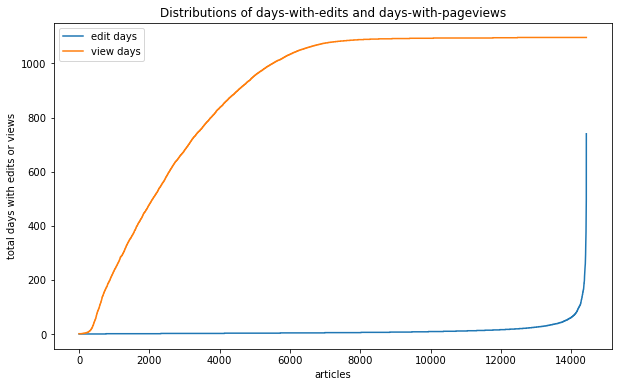

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1)
(edits > 0).sum(axis=0).sort_values().reset_index(drop=True).rename('edit days').plot(figsize=(10,6), ax=ax)
(views > 0).sum(axis=0).sort_values().reset_index(drop=True).rename('view days').plot(figsize=(10,6), ax=ax)
# views.
# ax.set_yscale('log')
ax.set_ylabel('total days with edits or views')
ax.set_xlabel('articles')
ax.set_title('Distributions of days-with-edits and days-with-pageviews')
ax.legend()
plt.show()

###### total edits compared to total views across articles

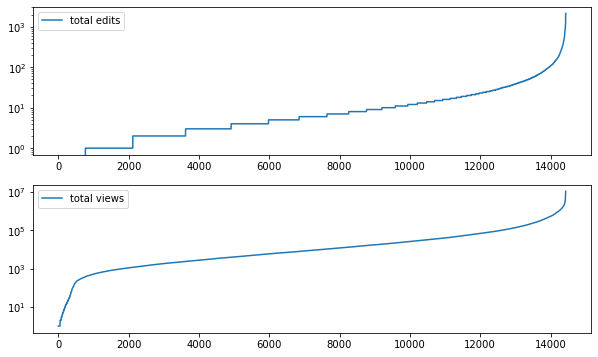

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1)
edits.sum(axis=0).sort_values().reset_index(drop=True).rename('total edits').plot(figsize=(10,6), ax=axes[0])
views.sum(axis=0).sort_values().reset_index(drop=True).rename('total views').plot(figsize=(10,6), ax=axes[1])
for ax in axes:    
    ax.legend()
    ax.set_yscale('log')

plt.show()

## model

##### generate calendar features

In [81]:
first_date = min(e.index) + dt.timedelta(days=1)
last_date = max(e.index) - dt.timedelta(days=1)

In [82]:
cal_7d = pd.DataFrame(index=e.index)
for i,d in enumerate(['mo','tu','we','th','fr','sa','su']):
    cal_7d[d] = e.index.dayofweek.isin([i]).astype(int)

cal = pd.DataFrame(index=e.index)
cal['mtwtf'] = e.index.dayofweek.isin([0,1,2,3,4]).astype(int)
cal['sat'] = e.index.dayofweek.isin([5]).astype(int)
cal['sat'] = e.index.dayofweek.isin([6]).astype(int)

###### INCLUDE HOLIDAYS AFTER I HAVE INTERNET AND CAN PIP INSTALL COUNTRYHOLIDAYS ETC

In [18]:
# # get japanese holidays in the relevant years
# years = list(set(e.index.year))
# holidays = list
# for y in years:
#     holidays.append(CountryHolidays.get('JP', y))
# holidays = pd.concat(holidays, axis=0)
# .set_index(0) ??

# holidays.index = holidays.index.tz_localize('Japan')
# holidays = holidays.resample('D').asfreq(' ').rename(columns={1:'holiday_name'})
# holidays['holiday'] = holidays.holiday_name.map(lambda x: int(x != ' '))

# bousai_days = bousai_days.join(holidays, how='left')
# bousai_days['holiday_name'] = bousai_days.holiday_name.fillna(' ')
# bousai_days['holiday'] = bousai_days.holiday.fillna(0).astype(int)
# bousai_days['holiday_on_weekday'] = bousai_days[['holiday', 'mtwtf']].all(axis='columns').astype(int)

In [19]:
# valid_dates = set(ys[pid].dropna().index).intersection(set(X.dropna().index))
# ys[pid] = ys[pid][valid_dates]

#### baseline regression on calendar, ar(1), and a one-week average

In [83]:
e_l1, e_l2, e_μ7, v_l1, v_l2, v_μ7 = {}, {}, {}, {}, {}, {}, 

for pid in busy_pageids:
    e_l1[pid] = e[pid].shift(1).rename(f'e_l1_{pid}')
    e_l2[pid] = e[pid].shift(2).rename(f'e_l2_{pid}')
    e_μ7[pid] = e[pid].rolling(6, closed='left').mean().rename(f'e_μ7_{pid}')
    v_l1[pid] = v[pid].shift(1).rename(f'v_l1_{pid}')
    v_l2[pid] = v[pid].shift(2).rename(f'v_l2_{pid}')
    v_μ7[pid] = v[pid].rolling(6, closed='left').mean().rename(f'v_μ7_{pid}')

###### for later

#### trying different features (mining between-article prediction) regression on calendar, ar(1), and a one-week average

In [98]:
R2_Stg1 = {}
for pid in busy_pageids:
    X = pd.concat((v_l1[pid],v_l2[pid],v_μ7[pid],cal), axis=1).dropna()
    y = v[pid][X.index]
    linreg = LinearRegression()
    linreg.fit(X.iloc[:600], y.iloc[:600])
    R2_Stg1[pid] = linreg.score(X.iloc[600:800], y.iloc[600:800])    
R2_Stg1 = pd.Series(R2_Stg1)

better_pids = R2_Stg1[R2_Stg1>0.2].index.to_list()

R2_Stg2 = {}
for pid in better_pids:    
    R2_Stg2[pid] = linreg.score(X.iloc[800:], y.iloc[800:])
R2_Stg2 = pd.Series(R2_Stg2)

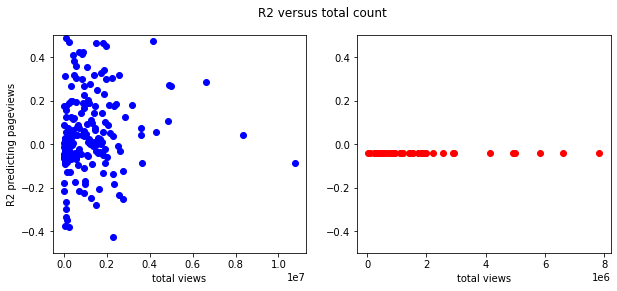

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(x=(v).sum(), y=R2_Stg1, color='blue')
ax2.scatter(x=(v[R2_Stg2.index]).sum(), y=R2_Stg2, color='red')
for ax in (ax1, ax2):
    ax.set_ylim(-.5,.5)
    ax.set_xlabel('total views')

ax1.set_ylabel('R2 predicting pageviews')

fig.suptitle('R2 versus total count')
plt.show()